With stop-word removal
-----------------------------

In [1]:
import sklearn.metrics
%matplotlib inline

import torch
import re
from torch.utils.data import DataLoader
import random
import time
import helper.sklearn_to_csv
from sklearn import metrics

In [2]:
COL_OPINION = 0
COL_SPEECH = 8

RUNS = 100
TEST_SPLIT = 0.15
VALID_SPLIT = 0.15
SHUFFLE = True
STRATIFY = True
CLASS_WEIGHTS = True
REMOVE_STOP_WORDS = False
STEMMING = False
LOWERING = False
NO_PUNCTUATION = False

OUT_NAME = f'measures_embeddingbag_01_{TEST_SPLIT}_{VALID_SPLIT}_Shuff{SHUFFLE}_Strat{STRATIFY}_Weigh{CLASS_WEIGHTS}_NoStop{REMOVE_STOP_WORDS}_Stem{STEMMING}_Low{LOWERING}_NoPun{NO_PUNCTUATION}'
PATH_METRICS = f'../results/{OUT_NAME}.csv'
PATH_DATASET = "../protocols/labelled/massnahmen_relevant.csv"
PATH_PERFORMANCE_GRAPH = f'../results/{OUT_NAME}.png'


In [3]:
label_class_map = {'-': 0, 'o': 1, '+': 2}


In [4]:
positive_samples = []
negative_samples = []
neutral_samples = []

with open(PATH_DATASET, 'r') as f:
    next(f)
    for line in f:
        col_vals = re.split('\\t', line)
        opinion = col_vals[COL_OPINION]
        sentence = col_vals[COL_SPEECH]
        if opinion == '+':
            positive_samples.append((2, sentence))
        elif opinion == '-':
            negative_samples.append((0, sentence))
        elif opinion == 'o':
            neutral_samples.append((1, sentence))

all_samples = positive_samples + negative_samples + neutral_samples

In [5]:
def get_train_test_split_proportional(data_tuples, test_split=TEST_SPLIT, shuffle=SHUFFLE):
    positive = [e for e in data_tuples if e[0] == 2]
    negative = [e for e in data_tuples if e[0] == 0]
    neutral = [e for e in data_tuples if e[0] == 1]

    neg_train = int(len(negative) * (1.0-test_split))
    neut_train = int(len(neutral) * (1.0-test_split))
    pos_train = int(len(positive) * (1.0-test_split))

    if shuffle:
        random.shuffle(positive)
        random.shuffle(negative)
        random.shuffle(neutral)
    train_data = positive[:pos_train] + negative[:neg_train] + neutral[:neut_train]
    valid_data = positive[pos_train:] + negative[neg_train:] + neutral[neut_train:]

    return train_data, valid_data, neg_train, neut_train, pos_train

# def get_train_test_split_proportional(data_tuples, ratio=TEST_SPLIT, shuffle=SHUFFLE):
#     pos = positive_samples.copy()
#     neg = negative_samples.copy()
#     neut = neutral_samples.copy()
#     if shuffle:
#         random.shuffle(pos)
#         random.shuffle(neg)
#         random.shuffle(neut)
#     test_samples = [(2,s) for s in pos[:int(ratio*len(pos))]] + \
#             [(0,s) for s in neg[:int(ratio*len(neg))]] + \
#             [(1,s) for s in neut[:int(ratio*len(neut))]]
#     train_samples = [(2,s) for s in pos[int(ratio*len(pos)):]] + \
#             [(0,s) for s in neg[int(ratio*len(neg)):]] + \
#             [(1,s) for s in neut[int(ratio*len(neut)):]]
#     return train_samples, test_samples

def get_train_test_split_even(per_class=50, shuffle=SHUFFLE):
    pos = positive_samples.copy()
    neg = negative_samples.copy()
    neut = neutral_samples.copy()
    if shuffle:
        random.shuffle(pos)
        random.shuffle(neg)
        random.shuffle(neut)
    train_samples = [(2,s) for s in pos[:per_class]] + \
            [(0,s) for s in neg[:per_class]] + \
            [(1,s) for s in neut[:per_class]]
    test_samples = [(2,s) for s in pos[per_class:]] + \
            [(0,s) for s in neg[per_class:]] + \
            [(1,s) for s in neut[per_class:]]
    return train_samples, test_samples

Prepare data processing pipelines
---------------------------------

In [6]:
from torchtext.data.utils import get_tokenizer
from collections import Counter
from torchtext.vocab import Vocab
import spacy
nlp = spacy.load('de_dep_news_trf')

tokenizer = get_tokenizer('spacy', language='de_dep_news_trf')
counter = Counter()
for sample in all_samples:
    counter.update(tokenizer(sample[1]))
vocab = Vocab(counter, min_freq=0)
text_pipeline = lambda x: [vocab[token] for token in tokenizer(x)]
label_pipeline = lambda x: label_class_map.get(x)

In [7]:
text_pipeline("Das das ist ein Test.")

[40, 8, 9, 30, 564, 3]

Generate data batch and iterator
--------------------------------

In [8]:
from torch.utils.data import DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def collate_batch(batch):
    class_list, text_list, offsets = [], [], [0]
    for (_class, _text) in batch:
         class_list.append(_class)
         processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
         text_list.append(processed_text)
         offsets.append(processed_text.size(0))
    label_list = torch.tensor(class_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list.to(device), text_list.to(device), offsets.to(device)

Define the model
----------------

In [9]:
from torch import nn

class TextClassificationModel(nn.Module):

    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)

Initiate an instance
--------------------

In [10]:
import time

def train(model, dataloader):
    model.train()
    total_acc, total_count = 0, 0
    log_interval = 25
    start_time = time.time()

    for idx, (label, text, offsets) in enumerate(dataloader):
        optimizer.zero_grad()
        predited_label = model(text, offsets)
        loss = criterion(predited_label, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        total_acc += (predited_label.argmax(1) == label).sum().item()
        total_count += label.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches '
                  '| accuracy {:8.3f}'.format(epoch, idx, len(dataloader),
                                              total_acc/total_count))
            total_acc, total_count = 0, 0
            start_time = time.time()


Evaluate the model with test dataset
------------------------------------

In [11]:
def evaluate(model, dataloader):
    model.eval()
    total_acc, total_count = 0, 0
    actual_labels = []
    predicted_labels = []

    with torch.no_grad():
        pred_pos = 0
        pred_neg = 0
        pred_neut = 0
        for idx, (label, text, offsets) in enumerate(dataloader):
            actual_labels += label.tolist()
            label_probs = model(text, offsets)
            predicted_label = label_probs.argmax(1)
            predicted_labels += predicted_label.tolist()
            c = Counter(predicted_label.tolist())
            pred_pos += c.get(2, 0)
            pred_neg += c.get(0, 0)
            pred_neut += c.get(1, 0)
            loss = criterion(label_probs, label)
            total_acc += (predicted_label == label).sum().item()
            total_count += label.size(0)
    return total_acc/total_count, pred_pos, pred_neg, pred_neut, metrics.classification_report(actual_labels, predicted_labels, output_dict=True)

In [13]:
# RUN MULTIPLE TIMES
accuracies = []
runs = RUNS
for i in range(runs):
    #train_ds, test_ds = get_train_test_split_even(90, True)
    if STRATIFY:
        train_ds_, test_ds, _, _, _ = get_train_test_split_proportional(all_samples, TEST_SPLIT, SHUFFLE)
        train_ds, valid_ds, neg_train, neut_train, pos_train = get_train_test_split_proportional(train_ds_, VALID_SPLIT, SHUFFLE)
    else:
        raise Exception('only stratify True is allowed')
    num_class = len(label_class_map)
    vocab_size = len(vocab)
    emsize = 64
    model = TextClassificationModel(vocab_size, emsize, num_class).to(device)

    # Hyperparameters
    EPOCHS = 10 # epoch
    LR = 5  # learning rate
    BATCH_SIZE = 16 # batch size for training
    if CLASS_WEIGHTS:
        max_count = max([neg_train, neut_train, pos_train])
        criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor([max_count/float(neg_train), max_count/float(neut_train), max_count/float(pos_train)]))
    else:
        criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=LR)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
    total_accu = None

    train_dataloader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=SHUFFLE, collate_fn=collate_batch)
    valid_dataloader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=SHUFFLE, collate_fn=collate_batch)
    test_dataloader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=SHUFFLE, collate_fn=collate_batch)

    for epoch in range(1, EPOCHS + 1):
        epoch_start_time = time.time()
        train(model, train_dataloader)
        accu_val, pred_pos, pred_neg, pred_neut, report = evaluate(model, valid_dataloader)
        if total_accu is not None and total_accu > accu_val:
          scheduler.step()
        else:
           total_accu = accu_val
        print('-' * 59)
        print('| end of epoch {:3d} | time: {:5.2f}s | valid accuracy {:8.3f} '.format(epoch, time.time() - epoch_start_time, accu_val))
        print('-' * 59)
    accu_test, pos, neg, neut, classification_report = evaluate(model, test_dataloader)
    helper.sklearn_to_csv.dict_to_csv(classification_report, PATH_METRICS)
    accuracies.append(accu_test)

| epoch   1 |    25/  231 batches | accuracy    0.399
| epoch   1 |    50/  231 batches | accuracy    0.295
| epoch   1 |    75/  231 batches | accuracy    0.417
| epoch   1 |   100/  231 batches | accuracy    0.400
| epoch   1 |   125/  231 batches | accuracy    0.412
| epoch   1 |   150/  231 batches | accuracy    0.412
| epoch   1 |   175/  231 batches | accuracy    0.530
| epoch   1 |   200/  231 batches | accuracy    0.497
| epoch   1 |   225/  231 batches | accuracy    0.507
-----------------------------------------------------------
| end of epoch   1 | time:  3.18s | valid accuracy    0.521 
-----------------------------------------------------------
| epoch   2 |    25/  231 batches | accuracy    0.548
| epoch   2 |    50/  231 batches | accuracy    0.537
| epoch   2 |    75/  231 batches | accuracy    0.580
| epoch   2 |   100/  231 batches | accuracy    0.530
| epoch   2 |   125/  231 batches | accuracy    0.557
| epoch   2 |   150/  231 batches | accuracy    0.557
| epoch  

/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

| epoch   2 |    25/  231 batches | accuracy    0.524
| epoch   2 |    50/  231 batches | accuracy    0.557
| epoch   2 |    75/  231 batches | accuracy    0.570
| epoch   2 |   100/  231 batches | accuracy    0.565
| epoch   2 |   125/  231 batches | accuracy    0.530
| epoch   2 |   150/  231 batches | accuracy    0.573
| epoch   2 |   175/  231 batches | accuracy    0.588
| epoch   2 |   200/  231 batches | accuracy    0.605
| epoch   2 |   225/  231 batches | accuracy    0.600
-----------------------------------------------------------
| end of epoch   2 | time:  1.59s | valid accuracy    0.569 
-----------------------------------------------------------
| epoch   3 |    25/  231 batches | accuracy    0.572
| epoch   3 |    50/  231 batches | accuracy    0.660
| epoch   3 |    75/  231 batches | accuracy    0.610
| epoch   3 |   100/  231 batches | accuracy    0.677
| epoch   3 |   125/  231 batches | accuracy    0.618
| epoch   3 |   150/  231 batches | accuracy    0.618
| epoch  

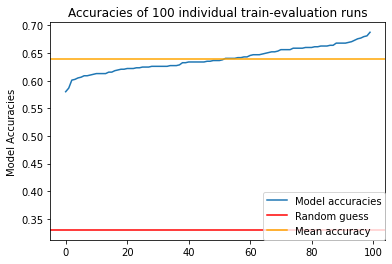

In [26]:
# plot accuracies
import matplotlib.pyplot as plt
plt.plot(sorted(accuracies), label='Model accuracies')
plt.axhline(y=0.33, color='r', linestyle='-', label='Random guess')
plt.axhline(y=sum(accuracies)/runs, color='orange', linestyle='-', label='Mean accuracy')
plt.ylabel('Model Accuracies')
plt.title(f"Accuracies of {runs} individual train-evaluation runs")
plt.legend(loc="lower right", borderaxespad=0)
plt.savefig(PATH_PERFORMANCE_GRAPH)
plt.show()


Test on a random sample
---------------------


In [ ]:
opinion_label = {0: "-",
                 1: "o",
                 2: "+"}

def predict(text, text_pipeline):
    with torch.no_grad():
        text = torch.tensor(text_pipeline(text))
        output = model(text, torch.tensor([0]))
        return output.argmax(1).item()

ex_text_str = "Alle können jetzt durch diesen Lockdown kom­men, weil die Coronakurzarbeit dafür adaptiert wurde."

print("The opinion is %s" %opinion_label[predict(ex_text_str, text_pipeline)])